In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def using_contours(image):
    # image = cv2.imread(src_img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold_value = 150
    pp, binary = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    contours,qq = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary)
    for contour in contours:
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    plt.imshow(segmented_image)
    return segmented_image

In [3]:
# import the necessary packages
from skimage import exposure

def using_match_histogram(img, ref_img):
	# load the source and reference images
	print("[INFO] loading source and reference images...")
	src = img
	ref = ref_img
	# determine if we are performing multichannel histogram matching
	# and then perform histogram matching itself
	print("[INFO] performing histogram matching...")
	multi = 2 if src.shape[-1] > 1 else None
	matched = exposure.match_histograms(src, ref, channel_axis=multi)
	plt.imshow(matched)
	return matched

In [4]:
def using_adaptive_threshold(src):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(src, cv2.COLOR_RGB2HSV)

    # Separate the value channel from the HSV image
    v = hsv[:,:,2]

    # Apply adaptive thresholding to create a mask for the shadow regions
    mask = cv2.adaptiveThreshold(v, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    # Soften the edges of the mask with a Gaussian blur
    mask = cv2.GaussianBlur(mask, (21,21), 0)
    plt.imshow(mask)    

    # Invert the mask so that the shadow regions are white
    mask = cv2.bitwise_not(mask)

    # Blend the original image with a white image using the mask as the alpha channel
    result = cv2.merge((v,v,v)) # Create a grayscale version of the image
    result = cv2.addWeighted(result, 0.9, cv2.merge((mask,mask,mask)), 0.1, 0)
    return result

In [5]:
def match_shadows_and_contrast(source_image, target_image):
# Convert the images to the HSV color space
  s_hsv = cv2.cvtColor(source_image, cv2.COLOR_RGB2HSV)
  t_hsv = cv2.cvtColor(target_image, cv2.COLOR_RGB2HSV)
  plt.imshow(s_hsv)
  # Get the shadows and highlights of the source image
  src_shadows = s_hsv[:, :, 2] < 128
  src_highlights = s_hsv[:, :, 2] > 255 / 2
  # print(src_shadows, src_highlights)

  # Set the shadows and highlights of the target image to match the source image
  t_hsv[src_shadows] = 0
  t_hsv[src_highlights] = 255
  t_hsv = cv2.GaussianBlur(t_hsv, (21,21), 0)
  # t_hsv = cv2.bitwise_not(t_hsv)
  # print(t_hsv)

    
  # Convert the target image back to the BGR color space
  result = cv2.cvtColor(t_hsv, cv2.COLOR_HSV2RGB)
  # result = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
  # plt.imshow(result)
  
  gray_src = cv2.cvtColor(source_image, cv2.COLOR_RGB2GRAY)
  result = cv2.addWeighted(target_image, 0.8, result, 0.2, -100)
  
  # Return the target image
  # return cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
  return result

In [6]:
def copy_values_hsv(source_image, target_image):
    # Convert the images to the HSV color space
    s_hsv = cv2.cvtColor(source_image, cv2.COLOR_RGB2HSV)
    t_hsv = cv2.cvtColor(target_image, cv2.COLOR_RGB2HSV)
    # plt.imshow(s_hsv)
    # Get the shadows and highlights of the source image
    src_shadows = s_hsv[:, :, 2] < 128
    src_highlights = s_hsv[:, :, 2] > 127
    # print(src_shadows, src_highlights)
    
    plt.imshow(t_hsv)
    t_hsv[src_shadows, 2] = s_hsv[src_shadows, 2]
    t_hsv[src_highlights, 2] = s_hsv[src_highlights, 2]

    res = cv2.cvtColor(t_hsv, cv2.COLOR_HSV2RGB)
    return res

In [7]:
def copy_lighting_lab(source_image, target_image):
    # Convert the images to the HSV color space
    s_lab = cv2.cvtColor(source_image, cv2.COLOR_RGB2LAB)
    t_lab = cv2.cvtColor(target_image, cv2.COLOR_RGB2LAB)

    # Get the shadows and highlights of the source image
    src_shadows = s_lab[:, :, 0] < 128
    src_highlights = s_lab[:, :, 0] > 127
    # print(src_shadows, src_highlights)
    
    # plt.imshow(t_lab)
    t_lab[src_shadows, 0] = s_lab[src_shadows, 0]
    t_lab[src_highlights, 0] = s_lab[src_highlights, 0]

    res = cv2.cvtColor(t_lab, cv2.COLOR_LAB2RGB)
    return res

In [25]:
def extract_lighting(source_image):
    # Convert the images to the HSV color space
    s_lab = cv2.cvtColor(source_image, cv2.COLOR_RGB2LAB)
    # t_lab = cv2.cvtColor(target_image, cv2.COLOR_RGB2LAB)
    tmp = np.zeros(s_lab.shape[:2])
    # Get the shadows and highlights of the source image
    src_shadows = s_lab[:, :, 0] < 128
    src_highlights = s_lab[:, :, 0] > 127
    # print(src_shadows, src_highlights)
    
    # plt.imshow(t_lab)
    tmp[src_shadows] = s_lab[src_shadows, 0]
    tmp[src_highlights] = s_lab[src_highlights, 0]

    # res = cv2.cvtColor(t_lab, cv2.COLOR_LAB2RGB)
    return tmp

In [12]:
def copy_lighting_lab1(source_image, target_image):
    # Convert the images to the HSV color space
    s_lab = cv2.cvtColor(source_image, cv2.COLOR_RGB2LAB)
    t_lab = cv2.cvtColor(target_image, cv2.COLOR_RGB2LAB)

    l = s_lab[:, :, 0]
    a = s_lab[:, :, 1]
    b = s_lab[:, :, 2]
    # print(l)
    mean_l = np.mean(l)
    std_l = np.std(l)
    mean_a = np.mean(a)
    mean_b = np.mean(b)

    if mean_a + mean_b <= 256:
        shadow_mask = l <= (mean_l-std_l/3)
    else:
        shadow_mask = (l < mean_l) & (b < mean_b)

    # # Get the shadows and highlights of the source image
    # src_shadows = s_lab[:, :, 0] < 128
    # src_highlights = s_lab[:, :, 0] > 127
    # # print(src_shadows, src_highlights)
    
    # # plt.imshow(t_lab)
    # t_lab[src_shadows, 0] = s_lab[src_shadows, 0]
    # t_lab[src_highlights, 0] = s_lab[src_highlights, 0]

    # res = cv2.cvtColor(t_lab, cv2.COLOR_LAB2RGB)
    return shadow_mask

In [13]:
from numpy.linalg import norm
def get_brightness(img):
    if len(img.shape) == 3:
        return np.average(norm(img, axis=2)) / np.sqrt(3)
    else:
        return np.average(img)

def change_brightness(src_img, subject):
    src_val = get_brightness(src_img)
    sub_val = get_brightness(subject)

    val = (sub_val - src_val)*0.2
    print(src_val, sub_val, val)
    hsv = cv2.cvtColor(subject, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, -val)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img

### Illuminating the overlayed img

In [14]:
test_img = "img3"

sample_wallpaper = cv2.cvtColor(cv2.imread('../inputs/products/Wallpapers/64_damask wallpaper texture-seamless.jpg'), cv2.COLOR_BGR2RGB)

src_img = cv2.cvtColor(cv2.imread("../inputs/src_imgs/{}.jpeg".format(test_img, test_img)), cv2.COLOR_BGR2RGB)
out_img = cv2.cvtColor(cv2.imread("../outs/{}.jpg".format(test_img)), cv2.COLOR_BGR2RGB)

In [58]:
ill = extract_lighting(src_img)
ill = np.stack([ill, ill, ill], axis=2)
# ill = np.array(ill, dtype=int)

In [62]:
ill

array([[[156., 156., 156.],
        [156., 156., 156.],
        [156., 156., 156.],
        ...,
        [117., 117., 117.],
        [116., 116., 116.],
        [116., 116., 116.]],

       [[156., 156., 156.],
        [156., 156., 156.],
        [156., 156., 156.],
        ...,
        [110., 110., 110.],
        [109., 109., 109.],
        [108., 108., 108.]],

       [[156., 156., 156.],
        [156., 156., 156.],
        [156., 156., 156.],
        ...,
        [107., 107., 107.],
        [105., 105., 105.],
        [104., 104., 104.]],

       ...,

       [[100., 100., 100.],
        [101., 101., 101.],
        [102., 102., 102.],
        ...,
        [ 51.,  51.,  51.],
        [ 47.,  47.,  47.],
        [ 54.,  54.,  54.]],

       [[100., 100., 100.],
        [101., 101., 101.],
        [102., 102., 102.],
        ...,
        [ 54.,  54.,  54.],
        [ 46.,  46.,  46.],
        [ 54.,  54.,  54.]],

       [[100., 100., 100.],
        [101., 101., 101.],
        [102., 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


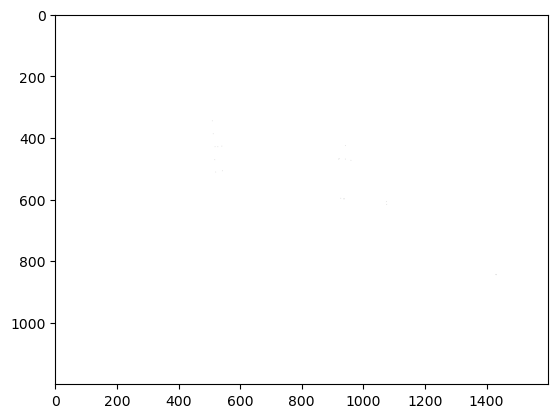

In [61]:
plt.imshow(ill)

In [33]:
cv2.addWeighted(src_img, 0.8, ill, 0.2, 0)

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


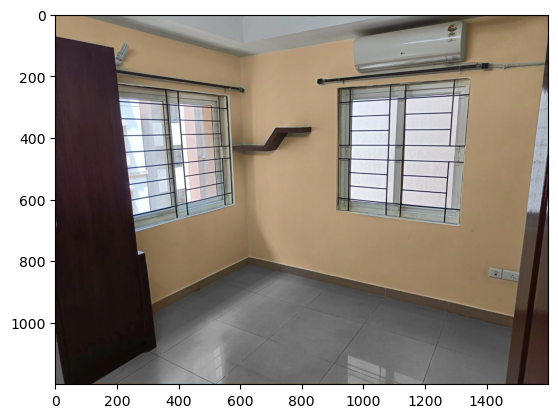

In [117]:
plt.imshow(ill)

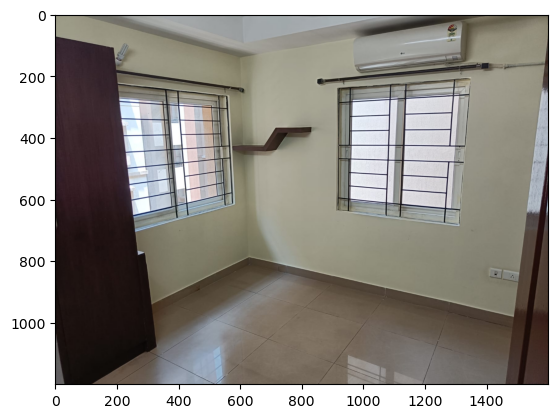

In [69]:
plt.imshow(src_img)

In [72]:
cv2.addWeighted(out_img, 0.8, ill, 0.2, 0)

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


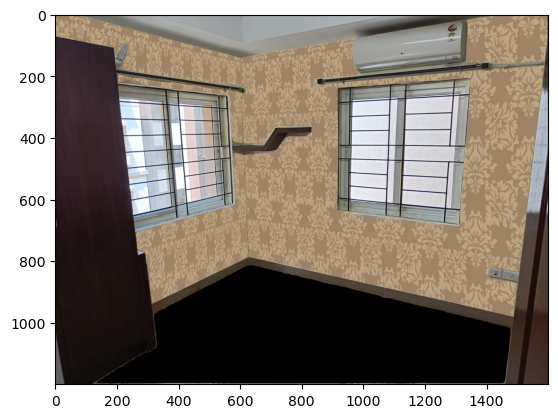

In [70]:
plt.imshow(out_img)